In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%%html
<style>
body {
    font-family: "Times New Roman";
    font-size: 12pt;
}
</style>  

In [3]:
"""
Created on Tue Nov  2 20:31:38 2018

@author:
Maximilian N. Günther
MIT Kavli Institute for Astrophysics and Space Research, 
Massachusetts Institute of Technology,
77 Massachusetts Avenue,
Cambridge, MA 02109, 
USA
Email: maxgue@mit.edu
Web: www.mnguenther.com
"""

from __future__ import print_function, division, absolute_import

#::: plotting settings
import seaborn as sns
sns.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context(rc={'lines.markeredgewidth': 1})

#::: modules
import numpy as np
import os, sys
import csv
import ipywidgets as widgets
from IPython.display import display, HTML, Markdown, clear_output, Javascript
display(HTML("<style>.container { width:80% !important; }</style>"))
from multiprocessing import cpu_count
if sys.version_info[0] == 3: # for Python3
    from tkinter import Tk, filedialog
elif sys.version_info[0] == 2: # for Python2
    from Tkinter import Tk
    import tkFileDialog as filedialog
import warnings
def custom_formatwarning(msg, *args, **kwargs):
    return str(msg) + '\n'
warnings.formatwarning = custom_formatwarning
    
#::: allesfitter modules
#::: somehow jupyter notebooks don't allow relative imports, so it needs a little hack...
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
import allesfitter
from allesfitter.utils.latex_printer import round_txt_separately
from allesfitter.priors.transform_priors import get_cosi_from_i, get_Rsuma_from_a_over_Rstar, get_Rsuma_from_Rstar_over_a
from allesfitter.priors.estimate_noise import estimate_noise

%load_ext autoreload
%autoreload 2

![allesfitter](logo_circ.png)

In [4]:
#::: globals
global INPUT
global VBOXES
global BUTTONS
global DROPDOWNS
INPUT = {}
VBOXES = {}
BUTTONS = {}
DROPDOWNS = {}
layout = {'width': '180px'}
layout_wide = {'width': '360px'}
layout_textbox = {'width': '120px'}
layout_checkbox = {}

In [5]:
#:::: clean up csv file
def clean_up_csv(fname, N_last_rows=0):
    
    with open(fname, "r") as f:
        params_csv = list(csv.reader(f))

    with open(fname, "w") as f:
        writer = csv.writer(f)
        for i in range(len(params_csv)-N_last_rows):
            row = params_csv[i]
            writer.writerow(row)
            

#:::: append a row into csv file              
def fwrite_params_line(text):
    with open(INPUT['fname_params'], 'a') as f:
        f.write(text+'\n')
        
            
#:::: write params into csv file            
def fwrite_params(key, label, unit, physical_bounds, return_str=False):
    if INPUT[key+'_bounds_type'].value == 'uniform':
        bounds = 'uniform ' \
                 + str( np.max( [physical_bounds[0], float(INPUT[key+'_median'].value)-float(INPUT[key+'_lerr'].value)] ) ) + ' ' \
                 + str( np.min( [physical_bounds[1], float(INPUT[key+'_median'].value)+float(INPUT[key+'_uerr'].value)] ) )
    elif INPUT[key+'_bounds_type'].value == 'uniform * 5':
        bounds = 'uniform ' \
                 + str( np.max( [physical_bounds[0], float(INPUT[key+'_median'].value)-5*float(INPUT[key+'_lerr'].value)] ) ) + ' ' \
                 + str( np.min( [physical_bounds[1], float(INPUT[key+'_median'].value)+5*float(INPUT[key+'_uerr'].value)] ) )
    elif INPUT[key+'_bounds_type'].value == 'trunc_normal':
        bounds = 'trunc_normal ' \
                 + str(physical_bounds[0]) + ' ' \
                 + str(physical_bounds[1]) + ' ' \
                 + str(INPUT[key+'_median'].value) + ' ' \
                 + str(np.max( [ float(INPUT[key+'_lerr'].value), float(INPUT[key+'_uerr'].value) ] ))
    elif INPUT[key+'_bounds_type'].value == 'trunc_normal * 5':
        bounds = 'trunc_normal ' \
                 + str(physical_bounds[0]) + ' ' \
                 + str(physical_bounds[1]) + ' ' \
                 + str(INPUT[key+'_median'].value) + ' ' \
                 + str(5*np.max( [ float(INPUT[key+'_lerr'].value), float(INPUT[key+'_uerr'].value) ] ))
    string = key + ',' + str(INPUT[key+'_median'].value) + ',' + str(int(INPUT[key+'_fit'].value)) + ',' +  bounds + ',' + label + ',' + unit
    if not return_str:
        fwrite_params_line(string)     
    else:
        return string
    
#unique
def unique(array):
    uniq, index = np.unique(array, return_index=True)
    return uniq[index.argsort()]

# 1. working directory

Select the working directory for this fit, for example `/Users/me/TESS-1b/`. Then you can run a fit using `allesfitter.ns_fit('/Users/me/TESS-1b/')`.

In [6]:
BUTTONS['datadir'] = widgets.Button(description='Select directory', button_style='')
text_af_directory = widgets.Text(value='', placeholder='for example: /Users/me/TESS-1b/', disable=True)
hbox = widgets.HBox([BUTTONS['datadir'], text_af_directory])
display(hbox)

def select_datadir(change):
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    INPUT['datadir'] = filedialog.askdirectory()
    %gui tk
    if INPUT['datadir'] != '':
        text_af_directory.value = INPUT['datadir']
        BUTTONS['datadir'].style.button_color = 'lightgreen'
        INPUT['show_step_2a'] = True
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
BUTTONS['datadir'].on_click(select_datadir)

<IPython.core.display.Javascript object>

# 2. settings

In [20]:
if 'show_step_2a' in INPUT and INPUT['show_step_2a'] == True:

    display(Markdown('### General settings'))
    
    
    DROPDOWNS['planet_or_EB'] = widgets.Dropdown(options=['Planets', 'EBs'])
    display( widgets.HBox([widgets.Label(value='Fitting planets or EBs?', layout=layout), DROPDOWNS['planet_or_EB']]) )
    
    
    display(Markdown('Give the companion letters and instruments, space-separated. Leave empty if not applicable.'))
    
    hbox_list = []
    
    text_companions_phot = widgets.Text(value='', placeholder='for example: b')
    hbox_list.append( widgets.HBox([widgets.Label(value='Companions in photometry', layout=layout), text_companions_phot]) )

    text_companions_rv = widgets.Text(value='', placeholder='for example: b c')
    hbox_list.append( widgets.HBox([widgets.Label(value='Companions in RV', layout=layout), text_companions_rv]) )

    text_inst_phot = widgets.Text(value='', placeholder='for example: TESS NGTS')
    hbox_list.append( widgets.HBox([widgets.Label(value='Instruments for photometry', layout=layout), text_inst_phot]) )

    text_inst_rv = widgets.Text(value='', placeholder='for example: HARPS Coralie')
    hbox_list.append( widgets.HBox([widgets.Label(value='Instruments for RV', layout=layout), text_inst_rv]) )

    display(widgets.VBox(hbox_list))
    
    def confirm(change):
        
        #::: set stuff
        if len(text_inst_phot.value): INPUT['inst_phot'] = str(text_inst_phot.value).split(' ')
        else: INPUT['inst_phot'] = []
        if len(text_inst_rv.value): INPUT['inst_rv'] = str(text_inst_rv.value).split(' ')
        else: INPUT['inst_rv'] = []

        if len(text_companions_phot.value): INPUT['companions_phot'] = str(text_companions_phot.value).split(' ')
        else: INPUT['companions_phot'] = []
        if len(text_companions_rv.value): INPUT['companions_rv'] = str(text_companions_rv.value).split(' ')
        else: INPUT['companions_rv'] = []

        INPUT['companions_all'] = list(np.unique(INPUT['companions_phot']+INPUT['companions_rv'])) #sorted by b, c, d...
        INPUT['inst_all'] = list(unique(INPUT['inst_phot']+INPUT['inst_rv'])) #sorted like user input
            
        button_2a.style.button_color = 'lightgreen'
        INPUT['show_step_2b'] = True
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
        
    button_2a = widgets.Button(description='Confirm', button_style='')
    display(button_2a)
    button_2a.on_click(confirm)

### General settings

Give the companion letters and instruments, space-separated. Leave empty if not applicable.

Button(description='Confirm', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [33]:
if 'show_step_2b' in INPUT and INPUT['show_step_2b'] == True:
    
    display(Markdown('### Advanced settings'))
    
    
    vbox_list = []
    
    #::: Fitting & performance
    hbox_list = []
    
    max_cores = cpu_count()
    DROPDOWNS['multiprocessing'] = widgets.Dropdown(options=['No'] + ['on '+str(i)+' of my '+str(max_cores)+' cores' for i in range(2,max_cores)] + ['always on all - 1 cores on any system'])
    hbox_list.append(widgets.HBox([widgets.Label(value='Multiprocessing', layout=layout), DROPDOWNS['multiprocessing']]))
    
    DROPDOWNS['fit_type'] = widgets.Dropdown(options=['Transit (fast)', 'Transit and occultation (fast)', 'Full lightcurve (slow)'])
    hbox_list.append(widgets.HBox([widgets.Label(value='Fit type', layout=layout), DROPDOWNS['fit_type']]))
    
    DROPDOWNS['shift_epoch'] = widgets.Dropdown(options=['Yes', 'No'])
    hbox_list.append(widgets.HBox([widgets.Label(value='Automatically shift epoch?', layout=layout), DROPDOWNS['shift_epoch']]))
    
    DROPDOWNS['mcmc_settings'] = widgets.Dropdown(options=['Default'])
    hbox_list.append(widgets.HBox([widgets.Label(value='MCMC settings', layout=layout), DROPDOWNS['mcmc_settings']]))
    
    DROPDOWNS['ns_settings'] = widgets.Dropdown(options=['Default'])
    hbox_list.append(widgets.HBox([widgets.Label(value='Nested Sampling settings', layout=layout), DROPDOWNS['ns_settings']]))
    
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Limb darkening
    hbox_list = []
    for inst in INPUT['inst_phot']:
        DROPDOWNS['host_ld_law_'+inst] = widgets.Dropdown(options=['None','Linear','Quadratic','Sing'], value='Quadratic')
        hbox_list.append( widgets.HBox([widgets.Label(value='Host limb darkening '+inst, layout=layout), DROPDOWNS['host_ld_law_'+inst]]) )
        if DROPDOWNS['planet_or_EB'].value == 'EBs':
            for companion in INPUT['companions_all']:
                DROPDOWNS[companion+'_ld_law_'+inst] = widgets.Dropdown(options=['None','Linear','Quadratic','Sing'])
                hbox_list.append( widgets.HBox([widgets.Label(value=companion+' limb darkening '+inst, layout=layout), DROPDOWNS[companion+'_ld_law_'+inst]]) )
    vbox_list.append( widgets.VBox(hbox_list) )

    
    #::: Baseline settings
    hbox_list = []
    for inst in INPUT['inst_phot']:
        DROPDOWNS['baseline_flux_'+inst] = widgets.Dropdown(options=['sample_offset', 'sample_linear', 'sample_GP_Matern32', 'sample_GP_SHO', 'sample_GP_real', 'sample_GP_complex', 'hybrid_offset', 'hybrid_poly_1', 'hybrid_poly_2', 'hybrid_poly_3', 'hybrid_poly_4', 'hybrid_spline'], value='hybrid_offset')
        hbox_list.append( widgets.HBox([widgets.Label(value='Baseline flux '+inst, layout=layout), DROPDOWNS['baseline_flux_'+inst]]) )
    for inst in INPUT['inst_rv']:
        DROPDOWNS['baseline_rv_'+inst] = widgets.Dropdown(options=['sample_offset', 'sample_linear', 'sample_GP_Matern32', 'sample_GP_SHO', 'sample_GP_real', 'sample_GP_complex', 'hybrid_offset', 'hybrid_poly_1', 'hybrid_poly_2', 'hybrid_poly_3', 'hybrid_poly_4', 'hybrid_spline'], value='hybrid_offset')
        hbox_list.append( widgets.HBox([widgets.Label(value='Baseline RV '+inst, layout=layout), DROPDOWNS['baseline_rv_'+inst]]) )
    vbox_list.append( widgets.VBox(hbox_list) )
   
    
    #::: Error settings
    hbox_list = []
    for inst in INPUT['inst_phot']:
        DROPDOWNS['error_flux_'+inst] = widgets.Dropdown(options=['sample', 'hybrid'], value='sample')
        hbox_list.append( widgets.HBox([widgets.Label(value='Error flux '+inst, layout=layout), DROPDOWNS['error_flux_'+inst]]) )
    for inst in INPUT['inst_rv']:
        DROPDOWNS['error_rv_'+inst] = widgets.Dropdown(options=['sample', 'hybrid'], value='sample')
        hbox_list.append( widgets.HBox([widgets.Label(value='Error RV '+inst, layout=layout), DROPDOWNS['error_rv_'+inst]]) )
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Exposure time interpolation
    hbox_list = []
    for inst in INPUT['inst_all']:
        DROPDOWNS['t_exp_'+inst] = widgets.Text( placeholder='None' )
        hbox_list.append( widgets.HBox([widgets.Label(value='Exposure time '+inst, layout=layout), DROPDOWNS['t_exp_'+inst], widgets.Label(value='days', layout=layout)]) )
    for inst in INPUT['inst_all']:
        DROPDOWNS['t_exp_n_int_'+inst] = widgets.Text( placeholder='None' )
        hbox_list.append( widgets.HBox([widgets.Label(value='Interpolation points '+inst, layout=layout), DROPDOWNS['t_exp_n_int_'+inst], widgets.Label(value='(integer)', layout=layout)]) )
    vbox_list.append( widgets.VBox(hbox_list) )
        
        
    #::: Number of spots
    hbox_list = []
    for inst in INPUT['inst_all']:
        DROPDOWNS['host_N_spots_'+inst] = widgets.Text( placeholder='None' )
        hbox_list.append( widgets.HBox([widgets.Label(value='host: Nr. of spots '+inst, layout=layout), DROPDOWNS['host_N_spots_'+inst], widgets.Label(value='(integer)', layout=layout)]) )
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Number of flares
    hbox_list = []
    DROPDOWNS['N_flares'] = widgets.Text( placeholder='None' )
    hbox_list.append( widgets.HBox([widgets.Label(value='Nr. of flares', layout=layout), DROPDOWNS['N_flares'], widgets.Label(value='(integer)', layout=layout)]) )
    vbox_list.append( widgets.VBox(hbox_list) )
        
        
    #::: Fit TTVs?
    hbox_list = []
    DROPDOWNS['fit_ttvs'] = widgets.Dropdown(options=["yes","no"], value="no")
    hbox_list.append( widgets.HBox([widgets.Label(value='Fit TTVs?', layout=layout), DROPDOWNS['fit_ttvs']]) )
    vbox_list.append( widgets.VBox(hbox_list) )
        
        
    #::: Stellar grid (e.g. use "sparse" to speed up intense spot computations)   
    hbox_list = []
    for inst in INPUT['inst_all']:
        DROPDOWNS['host_grid_'+inst] = widgets.Dropdown(options=["very_sparse", "sparse", "default", "fine", "very_fine"], value="default")
        hbox_list.append( widgets.HBox([widgets.Label(value='Host grid '+inst, layout=layout), DROPDOWNS['host_grid_'+inst]]) )
        if DROPDOWNS['planet_or_EB'].value == 'EBs':
            for companion in INPUT['companions_all']:
                DROPDOWNS[companion+'_grid_'+inst] = widgets.Dropdown(options=["very_sparse", "sparse", "default", "fine", "very_fine"], value="default")
                hbox_list.append( widgets.HBox([widgets.Label(value=companion+' grid '+inst, layout=layout), DROPDOWNS[companion+'_grid_'+inst]]) )
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Stellar shape (e.g. use "roche" for ellipsoidal variablity)
    hbox_list = []
    for inst in INPUT['inst_all']:
        DROPDOWNS['host_shape_'+inst] = widgets.Dropdown(options=["roche", "roche_v", "sphere", "poly1p5", "poly3p0", "love"], value="sphere")
        hbox_list.append( widgets.HBox([widgets.Label(value='Host shape '+inst, layout=layout), DROPDOWNS['host_shape_'+inst]]) )
        if DROPDOWNS['planet_or_EB'].value == 'EBs':
            for companion in INPUT['companions_all']:
                DROPDOWNS[companion+'_shape_'+inst] = widgets.Dropdown(options=["roche", "roche_v", "sphere", "poly1p5", "poly3p0", "love"], value="sphere")
                hbox_list.append( widgets.HBox([widgets.Label(value=companion+' shape '+inst, layout=layout), DROPDOWNS[companion+'_shape_'+inst]]) )
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Flux weighted RVs ("Yes" for Rossiter-McLaughlin effect)
    hbox_list = []
    for inst in INPUT['inst_rv']:
        for companion in INPUT['companions_rv']:
            DROPDOWNS[companion+'_flux_weighted_'+inst] = widgets.Dropdown(options=['No', 'Yes'])
            hbox_list.append( widgets.HBox([widgets.Label(value=companion+' flux weighted RV '+inst, layout=layout), DROPDOWNS[companion+'_flux_weighted_'+inst]]) )
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: accordion
    accordion = widgets.Accordion(children=vbox_list)
    accordion.set_title(0, 'Fitting & performance')
    accordion.set_title(1, 'Limb darkening laws')
    accordion.set_title(2, 'Baseline sampling')
    accordion.set_title(3, 'Error sampling')
    accordion.set_title(4, 'Exposure time interpolation')
    accordion.set_title(5, 'Number of spots')
    accordion.set_title(6, 'Number of flares')
    accordion.set_title(7, 'TTVs')
    accordion.set_title(8, 'Stellar grid (e.g. use "sparse" to speed up intense spot computations)')
    accordion.set_title(9, 'Stellar shape (e.g. use "roche" for ellipsoidal variablity)')
    accordion.set_title(10, 'Flux weighted RVs ("Yes" for Rossiter-McLaughlin effect)')
    display(accordion)
    
    
    #::: confirm button
    button_2b = widgets.Button(description='Confirm', button_style='')
    display(button_2b)

    def confirm(change):
        button_2b.style.button_color = 'lightgreen'
        INPUT['show_step_2c'] = True
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    button_2b.on_click(confirm)

### Advanced settings

Accordion(children=(VBox(children=(HBox(children=(Label(value='Multiprocessing', layout=Layout(width='180px'))…

Button(description='Confirm', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [45]:
if 'show_step_2c' in INPUT and INPUT['show_step_2c'] == True:

    BUTTONS['2c'] = widgets.Button(description='Create settings.csv', button_style='')
    checkbox_2c = widgets.Checkbox(description='Overwrite old settings.csv (if existing)', value=False)
    display(widgets.HBox([BUTTONS['2c'], checkbox_2c]))
    
    

    def create_settings_file(change):
        clear_output()
        display(widgets.HBox([BUTTONS['2c'], checkbox_2c]))

        go_ahead = True

        if 'datadir' not in INPUT:
            warnings.warn('No allesfitter woking directory selected yet. Please go back to step 1) and fill in all fields.')
            go_ahead = False

        if os.path.exists(os.path.join(INPUT['datadir'],'settings.csv')) and (checkbox_2c.value==False):
            warnings.warn('The selected working directory '+os.path.join(INPUT['datadir'],'settings.csv')+' already exists. To proceed, give permission to overwrite it.')
            go_ahead = False

        if go_ahead:
            fname_settings = os.path.join(INPUT['datadir'], 'settings.csv')
            with open(fname_settings, 'w+') as f:
                f.write('#name,value\n')

            def fwrite_settings(text):
                with open(fname_settings, 'a') as f:
                    f.write(text+'\n')
    

            fwrite_settings('###############################################################################,')
            fwrite_settings('# General settings,')
            fwrite_settings('###############################################################################,')
            fwrite_settings('companions_phot,'+text_companions_phot.value)
            fwrite_settings('companions_rv,'+text_companions_rv.value)
            fwrite_settings('inst_phot,'+text_inst_phot.value)
            fwrite_settings('inst_rv,'+text_inst_rv.value)

            
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Fit performance settings,')
            fwrite_settings('###############################################################################,')
            if DROPDOWNS['multiprocessing'].value=='No':
                fwrite_settings('multiprocess,False')
            elif DROPDOWNS['multiprocessing'].value=='always on all - 1 cores on any system':
                fwrite_settings('multiprocess,True')
                fwrite_settings('multiprocess_cores,all')
            else:
                fwrite_settings('multiprocess,True')
                fwrite_settings('multiprocess_cores,'+DROPDOWNS['multiprocessing'].value.split(' ')[1])
                
                
            if DROPDOWNS['fit_type'].value=='Transit (fast)':
                fwrite_settings('fast_fit,True')
                fwrite_settings('fast_fit_width,0.3333333333333333')
                fwrite_settings('secondary_eclipse,False')
                fwrite_settings('phase_curve,False')
            elif DROPDOWNS['fit_type'].value=='Transit and occultation (fast)':
                fwrite_settings('fast_fit,True')
                fwrite_settings('fast_fit_width,0.3333333333333333')
                fwrite_settings('secondary_eclipse,True')
                fwrite_settings('phase_curve,False')
            elif DROPDOWNS['fit_type'].value=='Full lightcurve (slow)':
                fwrite_settings('fast_fit,False')
                fwrite_settings('fast_fit_width,')
                fwrite_settings('secondary_eclipse,True')
                fwrite_settings('phase_curve,True')
                
                
            if DROPDOWNS['shift_epoch'].value=='Yes':
                fwrite_settings('shift_epoch,True')
                for companion in INPUT['companions_all']:
                    fwrite_settings('inst_for_'+companion+'_epoch,all')
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# MCMC settings,')
            fwrite_settings('###############################################################################,')
            if DROPDOWNS['mcmc_settings'].value=='Default':
                fwrite_settings('mcmc_nwalkers,100')
                fwrite_settings('mcmc_total_steps,2000')
                fwrite_settings('mcmc_burn_steps,1000')
                fwrite_settings('mcmc_thin_by,1')

                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Nested Sampling settings,')
            fwrite_settings('###############################################################################,')
            if DROPDOWNS['ns_settings'].value=='Default':
                fwrite_settings('ns_modus,dynamic')
                fwrite_settings('ns_nlive,500')
                fwrite_settings('ns_bound,single')
                fwrite_settings('ns_sample,rwalk')
                fwrite_settings('ns_tol,0.01')

                
            fwrite_settings('###############################################################################,')
            fwrite_settings("# Limb darkening law per object and instrument,")
            fwrite_settings("# if 'lin' one corresponding parameter called 'ldc_q1_inst' has to be given in params.csv,")
            fwrite_settings("# if 'quad' two corresponding parameter called 'ldc_q1_inst' and 'ldc_q2_inst' have to be given in params.csv,")
            fwrite_settings("# if 'sing' three corresponding parameter called 'ldc_q1_inst'; 'ldc_q2_inst' and 'ldc_q3_inst' have to be given in params.csv,")
            fwrite_settings('###############################################################################,')
            def translate_ld(x):
                if x=='None': return ''
                elif x=='Linear': return 'lin'
                elif x=='Quadratic': return 'quad'
                elif x=='Sing': return 'sing'
                
            for inst in INPUT['inst_phot']:
                fwrite_settings('host_ld_law_'+inst+','+translate_ld(DROPDOWNS['host_ld_law_'+inst].value))
                    
                if DROPDOWNS['planet_or_EB'].value == 'EBs':
                    for companion in INPUT['companions_all']:
                        fwrite_settings(companion+'_ld_law_'+inst+','+translate_ld(DROPDOWNS['host_ld_law_'+inst].value))
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings("# Baseline settings per instrument,")
            fwrite_settings("# baseline params per instrument: sample_offset / sample_linear / sample_GP / hybrid_offset / hybrid_poly_1 / hybrid_poly_2 / hybrid_poly_3 / hybrid_pol_4 / hybrid_spline / hybrid_GP,")
            fwrite_settings("# if 'sample_offset' one corresponding parameter called 'baseline_offset_key_inst' has to be given in params.csv,")
            fwrite_settings("# if 'sample_linear' two corresponding parameters called 'baseline_a_key_inst' and 'baseline_b_key_inst' have to be given in params.csv,")
            fwrite_settings("# if 'sample_GP' two corresponding parameters called 'baseline_gp1_key_inst' and 'baseline_gp2_key_inst' have to be given in params.csv,")
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_phot']:
                fwrite_settings('baseline_flux_'+inst+','+DROPDOWNS['baseline_flux_'+inst].value)
            for inst in INPUT['inst_rv']:
                fwrite_settings('baseline_rv_'+inst+','+DROPDOWNS['baseline_rv_'+inst].value)

                
            fwrite_settings('###############################################################################,')
            fwrite_settings("# Error settings per instrument,")
            fwrite_settings("# errors (overall scaling) per instrument: sample / hybrid,")
            fwrite_settings("# if 'sample' one corresponding parameter called 'log_err_key_inst' (photometry) or 'log_jitter_key_inst' (RV) has to be given in params.csv,")
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_phot']:
                fwrite_settings('error_flux_'+inst+','+DROPDOWNS['error_flux_'+inst].value)
            for inst in INPUT['inst_rv']:
                fwrite_settings('error_rv_'+inst+','+DROPDOWNS['error_rv_'+inst].value)
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Exposure times for interpolation,')
            fwrite_settings('# needs to be in the same units as the time series,')
            fwrite_settings('# if not given the observing times will not be interpolated leading to biased results,')
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_all']:
                fwrite_settings('t_exp_'+inst+','+DROPDOWNS['t_exp_'+inst].value)

                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Number of points for exposure interpolation,')
            fwrite_settings('# Sample as fine as possible; generally at least with a 2 min sampling for photometry,')
            fwrite_settings('# n_int=5 was found to be a good number of interpolation points for any short photometric cadence t_exp;,')
            fwrite_settings('# increase to at least n_int=10 for 30 min phot. cadence,')
            fwrite_settings('# the impact on RV is not as drastic and generally n_int=5 is fine enough,')
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_all']:
                fwrite_settings('t_exp_n_int_'+inst+','+DROPDOWNS['t_exp_n_int_'+inst].value)


            fwrite_settings('###############################################################################,')
            fwrite_settings('# Number of spots per object and instrument,')
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_all']:
                fwrite_settings('host_N_spots_'+inst+','+DROPDOWNS['host_N_spots_'+inst].value)
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Number of flares (in total),')
            fwrite_settings('###############################################################################,')
            fwrite_settings('N_flares'+','+DROPDOWNS['N_flares'].value)
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# TTVs,')
            fwrite_settings('###############################################################################,')
            if DROPDOWNS['fit_ttvs'].value == 'no':
                fwrite_settings('fit_ttvs'+',False')
            elif DROPDOWNS['fit_ttvs'].value == 'yes':
                fwrite_settings('fit_ttvs'+',True')
                        
                        
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Stellar grid per object and instrument,')
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_all']:
                fwrite_settings('host_grid_'+inst+','+DROPDOWNS['host_grid_'+inst].value)
                if DROPDOWNS['planet_or_EB'].value == 'EBs':
                    for companion in INPUT['companions_all']:
                        fwrite_settings(companion+'_grid_'+inst+','+DROPDOWNS[companion+'_grid_'+inst].value)
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Stellar shape per object and instrument,')
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_all']:
                fwrite_settings('host_shape_'+inst+','+DROPDOWNS['host_shape_'+inst].value)
                if DROPDOWNS['planet_or_EB'].value == 'EBs':
                    for companion in INPUT['companions_all']:
                        fwrite_settings(companion+'_shape_'+inst+','+DROPDOWNS[companion+'_shape_'+inst].value)
                
                
            fwrite_settings('###############################################################################,')
            fwrite_settings('# Flux weighted RVs per object and instrument,')
            fwrite_settings('# ("Yes" for Rossiter-McLaughlin effect),')
            fwrite_settings('###############################################################################,')
            for inst in INPUT['inst_rv']:
                for companion in INPUT['companions_rv']:
                    fwrite_settings(companion+'_flux_weighted_'+inst+','+DROPDOWNS[companion+'_flux_weighted_'+inst].value)
                
                
            BUTTONS['2c'].style.button_color = 'lightgreen' 
            print('Done.') 
            INPUT['show_step_3'] = True
            display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))


    BUTTONS['2c'].on_click(create_settings_file)

Done.


<IPython.core.display.Javascript object>

# 3. parameters

In [56]:
if 'show_step_3' in INPUT and INPUT['show_step_3'] == True:

    #::: placeholder
    placeholder = widgets.Label(value='', visible=False, layout=layout)

    
    
    #::: helper function
    def add_row(key, label, hbox_list, median=0, lerr=0, uerr=0, transform='trunc_normal * 5', fit_value=False):
        INPUT[key+'_median'] = widgets.FloatText(value=median, placeholder='NaN', layout=layout_textbox)
        INPUT[key+'_lerr']   = widgets.FloatText(value=lerr, placeholder='NaN', layout=layout_textbox)
        INPUT[key+'_uerr']   = widgets.FloatText(value=uerr, placeholder='NaN', layout=layout_textbox)
        INPUT[key+'_bounds_type']   = widgets.Dropdown(options=['uniform', 'uniform * 5', 'trunc_normal', 'trunc_normal * 5'], value=transform, layout=layout)
        INPUT[key+'_fit']    = widgets.Checkbox(value=fit_value, description='fit?', layout=layout_checkbox)
        
        buf = placeholder
        if key in [ companion+'_rsuma' for companion in INPUT['companions_all'] ]:
            INPUT[key+'_input_type'] = widgets.Dropdown(options=['(R_comp + R_host) / a', 'R_host / a', 'a / R_host'], layout=layout)
            buf = INPUT[key+'_input_type']
        elif key in [ companion+'_cosi' for companion in INPUT['companions_all'] ]:
            INPUT[key+'_input_type'] = widgets.Dropdown(options=['cos(i)', 'i (degree)', 'i (rad)'], layout=layout)
            buf = INPUT[key+'_input_type']
                
        hbox_list.append( widgets.HBox([widgets.Label(value=label, layout=layout), 
                       INPUT[key+'_median'], 
                       widgets.Label(value="-"), INPUT[key+'_lerr'], 
                       widgets.Label(value="+"), INPUT[key+'_uerr'],   
                       buf, 
                       INPUT[key+'_bounds_type'],
                       INPUT[key+'_fit']]) )
    
    
    
    #::: start
    display(Markdown('### Initial guess and error bars'))
    display(Markdown('These values will be converted into either uniform or truncated normal priors (with physical boundaries). The errors can be blown up by a factor of 5.'))    
    
    
    
    display(Markdown('#### Astrophysical params per companion'))
    vbox_list = []
    for companion in INPUT['companions_all']:
        
#         display(Markdown('##### Companion '+companion))
        
        hbox_list = []
        add_row(companion+'_rsuma', 'Radii & semi-major axis:', hbox_list)
        add_row(companion+'_rr', '$R_'+companion+' / R_\star$:', hbox_list)
        add_row(companion+'_cosi', 'Inclination:', hbox_list)
        add_row(companion+'_epoch', 'Epoch (d):', hbox_list)
        add_row(companion+'_period', 'Period (d):', hbox_list)
        if companion in INPUT['companions_rv']:
            add_row(companion+'_K', 'K (km/s):', hbox_list)
        add_row(companion+'_f_c', '$\sqrt{e} \cos{\omega}$:', hbox_list)
        add_row(companion+'_f_s', '$\sqrt{e} \sin{\omega}$:', hbox_list)
        vbox_list.append( widgets.VBox(hbox_list) )
    
    tab = widgets.Tab(children=vbox_list)
    for i, comp in enumerate(INPUT['companions_all']):
        tab.set_title(i, 'Companion '+comp)
    display(tab)
    
    
    
# else:
#     print('Complete previous steps first.')

### Initial guess and error bars

These values will be converted into either uniform or truncated normal priors (with physical boundaries). The errors can be blown up by a factor of 5.

#### Astrophysical params per companion

In [57]:
if 'show_step_3' in INPUT and INPUT['show_step_3'] == True:
    
    display(Markdown('### Advanced params'))
    vbox_list = []
    
    
    #::: Dilution per instrument
    hbox_list = []
    for inst in INPUT['inst_phot']:
        add_row('dil_'+inst, 'Dilution '+inst, hbox_list)
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Limb darkening per object and instrument
    hbox_list = []
    for inst in INPUT['inst_phot']:
        if DROPDOWNS['host_ld_law_'+inst].value=='None':
            pass
        elif DROPDOWNS['host_ld_law_'+inst].value=='Linear':
            add_row('host_ldc_q1_'+inst, 'host LD q1 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
        elif DROPDOWNS['host_ld_law_'+inst].value=='Quadratic':
            add_row('host_ldc_q1_'+inst, 'host LD q1 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
            add_row('host_ldc_q2_'+inst, 'host LD q2 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
        elif DROPDOWNS['host_ld_law_'+inst].value=='Sing':
            add_row('host_ldc_q1_'+inst, 'host LD q1 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
            add_row('host_ldc_q2_'+inst, 'host LD q2 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
            add_row('host_ldc_q3_'+inst, 'host LD q3 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
            
        if DROPDOWNS['planet_or_EB']=='EBs':
            for companion in INPUT['companions_phot']:
                if DROPDOWNS[companion+'_ld_law_'+inst].value=='None':
                    pass
                elif DROPDOWNS[companion+'_ld_law_'+inst].value=='Linear':
                    add_row(companion+'_ldc_q1_'+inst, companion+' LD q1 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
                elif DROPDOWNS[companion+'_ld_law_'+inst].value=='Quadratic':
                    add_row(companion+'_ldc_q1_'+inst, companion+' LD q1 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
                    add_row(companion+'_ldc_q2_'+inst, companion+' LD q2 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
                elif DROPDOWNS[companion+'_ld_law_'+inst].value=='Sing':
                    add_row(companion+'_ldc_q1_'+inst, companion+' LD q1 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
                    add_row(companion+'_ldc_q2_'+inst, companion+' LD q2 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
                    add_row(companion+'_ldc_q3_'+inst, companion+' LD q3 '+inst, hbox_list, median=0.5, lerr=0.5, uerr=0.5, transform='uniform', fit_value=True)
                
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Surface brightness ratio per system and instrument
    hbox_list = []
    for inst in INPUT['inst_all']:
        for companion in INPUT['companions_all']:
            add_row(companion+'_sbratio_'+inst, companion+' sbratio '+inst, hbox_list)
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Geometric albedo per object and instrument
    hbox_list = []
    for inst in INPUT['inst_all']:
        add_row('host_geom_albedo_'+inst, 'host geom. alb. '+inst, hbox_list)
        for companion in INPUT['companions_all']:
            add_row(companion+'_geom_albedo_'+inst, companion+' geom. alb. '+inst, hbox_list)
    vbox_list.append( widgets.VBox(hbox_list) )
    
        
    #::: Gravity darkening per object and instrument
    hbox_list = []
    for inst in INPUT['inst_all']:
        add_row('host_gdc_'+inst, 'host grav. dark. '+inst, hbox_list)
        if DROPDOWNS['planet_or_EB']=='EBs':
            for companion in INPUT['companions_all']:
                add_row(companion+'_gdc_'+inst, companion+' grav. dark. '+inst, hbox_list)
    vbox_list.append( widgets.VBox(hbox_list) )
        

    #::: Stellar spots per object and instrument
    hbox_list = []
    for inst in INPUT['inst_all']:
        
        if len(DROPDOWNS['host_N_spots_'+inst].value):
            N_spots = int(DROPDOWNS['host_N_spots_'+inst].value)
            for i in range(1,N_spots+1):
                add_row('host_spot_'+str(i)+'_lat_'+inst, 'host spot '+str(i)+' lat. '+inst+' (deg)', hbox_list)
                add_row('host_spot_'+str(i)+'_long_'+inst, 'host spot '+str(i)+' long. '+inst+' (deg)', hbox_list)
                add_row('host_spot_'+str(i)+'_size_'+inst, 'host spot '+str(i)+' size '+inst+' (deg)', hbox_list)
                add_row('host_spot_'+str(i)+'_brightness_'+inst,'host spot '+str(i)+' brightness '+inst, hbox_list)

        if DROPDOWNS['planet_or_EB'].value == 'EBs':
            for companion in INPUT['companions_all']:
                if len(DROPDOWNS[companion+'_N_spots_'+inst].value):
                    N_spots = int(DROPDOWNS[companion+'_N_spots_'+inst].value)
                    for i in range(1,N_spots+1):
                        add_row(companion+'_spot_'+str(i)+'_lat_'+inst, companion+' spot '+str(i)+' lat. '+inst+' (deg)', hbox_list)
                        add_row(companion+'_spot_'+str(i)+'_long_'+inst, companion+' spot '+str(i)+' long. '+inst+' (deg)', hbox_list)
                        add_row(companion+'_spot_'+str(i)+'_size_'+inst, companion+' spot '+str(i)+' size '+inst+' (deg)', hbox_list)
                        add_row(companion+'_spot_'+str(i)+'_brightness_'+inst, companion+' spot '+str(i)+' brightness '+inst, hbox_list)
                        
    if len(hbox_list)==0:
        pass
        #hbox_list.append(widgets.Label(value='N_spots was set to "None" for all objects and instruments.'))
    vbox_list.append( widgets.VBox(hbox_list) )


    #::: Flares
    hbox_list = []
    if len(DROPDOWNS['N_flares'].value):
        N_flares = int(DROPDOWNS['N_flares'].value)
        for i in range(1,N_flares+1):
            add_row('flare_tpeak_'+str(i), 'Flare tpeak '+str(i), hbox_list)
            add_row('flare_fwhm_'+str(i), 'Flare fwhm '+str(i), hbox_list)
            add_row('flare_ampl_'+str(i), 'Flare ampl '+str(i), hbox_list)
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: TTV per transit
    hbox_list = []
    if (DROPDOWNS['fit_ttvs'].value)=='yes':
        for companion in INPUT['companions_all']:
            add_row(companion+'_ttv_per_transit', 'TTV per transit', hbox_list, median=0, lerr=0.00347222, uerr=0.00347222, transform='uniform', fit_value=True)
    vbox_list.append( widgets.VBox(hbox_list) )
    
        
    #::: Errors per instrument
    hbox_list = []
    
    for inst in INPUT['inst_phot']:
        if DROPDOWNS['error_flux_'+inst].value == 'sample':
            add_row('log_err_flux_'+inst, 'log err flux '+inst, hbox_list, median=-7, lerr=8, uerr=7, transform='uniform', fit_value=True)
        else:
            pass
            #hbox_list.append(widgets.Label(value='Not applicable, error sampling was set to "hybrid".'))
        
    for inst in INPUT['inst_rv']:
        if DROPDOWNS['error_rv_'+inst].value == 'sample':
            add_row('log_jitter_rv_'+inst, 'log jitter rv '+inst, hbox_list, median=-3, lerr=12, uerr=3, transform='uniform', fit_value=True)
        else:
            pass
            #hbox_list.append(widgets.Label(value='Not applicable, error sampling was set to "hybrid".'))
            
    vbox_list.append( widgets.VBox(hbox_list) )
    
    
    #::: Baselines per instrument
    hbox_list = []
    for inst in INPUT['inst_all']:
        if inst in INPUT['inst_phot']:
            key = 'flux'
        elif inst in INPUT['inst_rv']:
            key = 'rv'
            
        if DROPDOWNS['baseline_'+key+'_'+inst].value == 'sample_GP_Matern32':
                add_row('baseline_gp_matern32_lnsigma_'+key+'_'+inst, 'baseline gp Matern32 lnsigma '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_matern32_lnrho_'+key+'_'+inst, 'baseline gp Matern32 lnrho '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
        elif DROPDOWNS['baseline_'+key+'_'+inst].value == 'sample_GP_SHO':
                add_row('baseline_gp_sho_lnS0_'+key+'_'+inst, 'baseline gp SHO lnS0 '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_sho_lnQ_'+key+'_'+inst, 'baseline gp SHO lnQ '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_sho_lnomega_'+key+'_'+inst, 'baseline gp SHO lnomega '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
        elif DROPDOWNS['baseline_'+key+'_'+inst].value == 'sample_GP_real':
                add_row('baseline_gp_real_lna_'+key+'_'+inst, 'baseline gp real lna '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_real_lnc_'+key+'_'+inst, 'baseline gp real lnc '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
        elif DROPDOWNS['baseline_'+key+'_'+inst].value == 'sample_GP_complex':
                add_row('baseline_gp_complex_lna_'+key+'_'+inst, 'baseline gp complex lna '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_complex_lnc_'+key+'_'+inst, 'baseline gp complex lnc '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_complex_lna_'+key+'_'+inst, 'baseline gp complex lnb '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
                add_row('baseline_gp_complex_lnc_'+key+'_'+inst, 'baseline gp complex lnd '+inst, hbox_list, median=0, lerr=15, uerr=15, transform='uniform', fit_value=True)
        elif DROPDOWNS['baseline_'+key+'_'+inst].value == 'sample_offset':
                add_row('baseline_offset_'+key+'_'+inst, 'baseline offset '+inst, hbox_list, median=0, lerr=0, uerr=0, transform='uniform', fit_value=True)
        elif DROPDOWNS['baseline_'+key+'_'+inst].value == 'sample_linear':
                add_row('baseline_offset_'+key+'_'+inst, 'baseline offset '+inst, hbox_list, median=0, lerr=0, uerr=0, transform='uniform', fit_value=True)
                add_row('baseline_slope_'+key+'_'+inst, 'baseline slope '+inst, hbox_list, median=0, lerr=0, uerr=0, transform='uniform', fit_value=True)
    
    vbox_list.append( widgets.VBox(hbox_list) )
    
            
    #::: accordion
    accordion = widgets.Accordion(children=vbox_list)
    accordion.set_title(0, 'Dilution')
    accordion.set_title(1, 'Limb darkening')
    accordion.set_title(2, 'Surface brightness ratio')
    accordion.set_title(3, 'Geometric albedo')
    accordion.set_title(4, 'Gravity darkening')
    accordion.set_title(5, 'Stellar spots')
    accordion.set_title(6, 'Flares')
    accordion.set_title(7, 'TTVs')
    accordion.set_title(8, 'Errors & jitter')
    accordion.set_title(9, 'Baselines')
    display(accordion)
            

### Advanced params

Accordion(children=(VBox(children=(HBox(children=(Label(value='Dilution Leonardo', layout=Layout(width='180px'…

In [58]:
if 'show_step_3' in INPUT and INPUT['show_step_3'] == True:
    
    nan_fields = False
    
    button_create_params_file = widgets.Button(description='Create params.csv', button_style='')
    checkbox_overwrite_params_file = widgets.Checkbox(description='Overwrite old params.csv (if existing)', value=False)
    hbox_params_file = widgets.HBox([button_create_params_file, checkbox_overwrite_params_file])
    display(hbox_params_file)
    
    def create_params_file(change):
        
        clear_output()
        display(hbox_params_file)
        print('Calculating... this might take a few seconds. Please be patient, you will get notified once everything is completed.')

        go_ahead = True

        if 'datadir' not in INPUT:
            warnings.warn('No allesfitter woking directory selected yet. Please go back to step 1) and fill in all fields.')
            go_ahead = False

        if os.path.exists(os.path.join(INPUT['datadir'],'params.csv')) and (checkbox_overwrite_params_file.value==False):
            warnings.warn('The selected working directory '+os.path.join(INPUT['datadir'],'params.csv')+' already exists. To proceed, give permission to overwrite it.')
            go_ahead = False

            
        if go_ahead:
            INPUT['fname_params'] = os.path.join(INPUT['datadir'], 'params.csv')
            with open(INPUT['fname_params'], 'w+') as f:
                f.write('#name,value,fit,bounds,label,unit\n')

            
            
            def get_median_and_error_strings(text_median, text_lerr, text_uerr):
                if (text_median.value == ''):
                    median = 'NaN'
                    nan_fields = True
                else:
                    median = text_median.value
                if (text_lerr.value == '') or (text_uerr.value == ''):
                    err = 'NaN'
                    nan_fields = True
                else:
                    err = str( 5.* np.max( [float(text_lerr.value), float(text_uerr.value)] ) )
                median, err, _ = round_txt_separately( float(median), float(err), float(err) )
                return median, err
                 

    
            #:::: astrophysical parameters per system
            for companion in INPUT['companions_all']:
                fwrite_params_line('#companion '+companion+' astrophysical params,,,,,') 
                
                #::: rr
                fwrite_params(companion+'_rr', '$R_'+companion+' / R_\star$', '', [0,1])
                
                #::: rsuma
                if INPUT[companion+'_rsuma_input_type'].value=='(R_comp + R_host) / a':
                    pass
                elif INPUT[companion+'_rsuma_input_type'].value=='R_host / a':
                    Rstar_over_a = [ float(INPUT[companion+'_rsuma_median'].value), float(INPUT[companion+'_rsuma_lerr'].value), float(INPUT[companion+'_rsuma_uerr'].value) ]
                    Rp_over_Rstar = [ float(INPUT[companion+'_rr_median'].value), float(INPUT[companion+'_rr_lerr'].value), float(INPUT[companion+'_rr_uerr'].value) ]
                    INPUT[companion+'_rsuma_median'].value, INPUT[companion+'_rsuma_lerr'].value, INPUT[companion+'_rsuma_uerr'].value \
                        = get_Rsuma_from_Rstar_over_a(Rstar_over_a, Rp_over_Rstar)
                    INPUT[companion+'_rsuma_input_type'].value = '(R_comp + R_host) / a'
                elif INPUT[companion+'_rsuma_input_type'].value=='a / R_host':
                    a_over_Rstar = [ float(INPUT[companion+'_rsuma_median'].value), float(INPUT[companion+'_rsuma_lerr'].value), float(INPUT[companion+'_rsuma_uerr'].value) ]
                    Rp_over_Rstar = [ float(INPUT[companion+'_rr_median'].value), float(INPUT[companion+'_rr_lerr'].value), float(INPUT[companion+'_rr_uerr'].value) ]
                    INPUT[companion+'_rsuma_median'].value, INPUT[companion+'_rsuma_lerr'].value, INPUT[companion+'_rsuma_uerr'].value \
                        = get_Rsuma_from_a_over_Rstar(a_over_Rstar, Rp_over_Rstar)
                    INPUT[companion+'_rsuma_input_type'].value = '(R_comp + R_host) / a'
                else:
                    raise ValueError('Oops, something went wrong.')
                fwrite_params(companion+'_rsuma', '$(R_\star + R_'+companion+') / a_'+companion+'$', '', [0,1])
                
                #::: cosi
                if INPUT[companion+'_cosi_input_type'].value=='cos(i)':
                    pass
                elif INPUT[companion+'_cosi_input_type'].value=='i (degree)':
                    incl = [ float(INPUT[companion+'_cosi_median'].value), float(INPUT[companion+'_cosi_lerr'].value), float(INPUT[companion+'_cosi_uerr'].value) ]
                    INPUT[companion+'_cosi_median'].value, INPUT[companion+'_cosi_lerr'].value, INPUT[companion+'_cosi_uerr'].value \
                        = get_cosi_from_i(incl)
                    INPUT[companion+'_cosi_input_type'].value = 'cos(i)'
                elif INPUT[companion+'_cosi_input_type'].value=='i (rad)':
                    incl = [ float(INPUT[companion+'_cosi_median'].value)/180.*np.pi, float(INPUT[companion+'_cosi_lerr'].value)/180.*np.pi, float(INPUT[companion+'_cosi_uerr'].value)/180.*np.pi ]
                    INPUT[companion+'_cosi_median'].value, INPUT[companion+'_cosi_lerr'].value, INPUT[companion+'_cosi_uerr'].value \
                        = get_cosi_from_i(incl)
                    INPUT[companion+'_cosi_input_type'].value = 'cos(i)'
                fwrite_params(companion+'_cosi', '$\cos{i_'+companion+'}$', '', [0,1])

                #::: epoch
                fwrite_params(companion+'_epoch', '$T_{0;'+companion+'}$', '$\mathrm{BJD}$', [-1e12,1e12])

                #::: period
                fwrite_params(companion+'_period', '$P_'+companion+'$', '$\mathrm{d}$', [-1e12,1e12])
                
                #::: RV semi-amplitude
                if companion in INPUT['companions_rv']:
                    fwrite_params(companion+'_K', '$K_'+companion+'$', '$\mathrm{km/s}$', [-1e12,1e12])
                              
                #::: eccentricity f_c
                fwrite_params(companion+'_f_c', '$\sqrt{e_'+companion+'} \cos{\omega_'+companion+'}$', '', [-1,1])
                              
                #::: eccentricity f_s
                fwrite_params(companion+'_f_s', '$\sqrt{e_'+companion+'} \sin{\omega_'+companion+'}$', '', [-1,1])

                
            #::: dilution per instrument
            if len(INPUT['inst_phot']):
                fwrite_params_line('#dilution per instrument,,,,,')
                for inst in INPUT['inst_phot']:
                    fwrite_params('dil_'+inst, '$D_\mathrm{0; '+inst+'}$', '', [0,1])
                    #fwrite_params('dil_'+inst+',0,0,trunc_normal 0 1 0 0,$D_\mathrm{0; '+inst+'}$,')

                
            #::: limb darkening coefficients per instrument
            if len(INPUT['inst_phot']):
                fwrite_params_line('#limb darkening coefficients per instrument,,,,,')     
                for inst in INPUT['inst_phot']:
                    
                    #::: host
                    if DROPDOWNS['host_ld_law_'+inst].value=='None':
                        pass
                    elif DROPDOWNS['host_ld_law_'+inst].value=='Linear':
                        fwrite_params('host_ldc_q1_'+inst, '$q_{1; \mathrm{'+inst+'}}$', '', [0,1])   
                    elif DROPDOWNS['host_ld_law_'+inst].value=='Quadratic':
                        fwrite_params('host_ldc_q1_'+inst, '$q_{1; \mathrm{'+inst+'}}$', '', [0,1])     
                        fwrite_params('host_ldc_q2_'+inst, '$q_{2; \mathrm{'+inst+'}}$', '', [0,1])    
                    elif DROPDOWNS['host_ld_law_'+inst].value=='Sing':
                        fwrite_params('host_ldc_q1_'+inst, '$q_{1; \mathrm{'+inst+'}}$', '', [0,1])     
                        fwrite_params('host_ldc_q2_'+inst, '$q_{2; \mathrm{'+inst+'}}$', '', [0,1])      
                        fwrite_params('host_ldc_q3_'+inst, '$q_{3; \mathrm{'+inst+'}}$', '', [0,1]) 
                        
                    #::: companion (if EB)
                    if DROPDOWNS['planet_or_EB']=='EBs':
                        if DROPDOWNS[companion+'_ld_law_'+inst].value=='None':
                            pass
                        elif DROPDOWNS[companion+'_ld_law_'+inst].value=='Linear':
                            fwrite_params(companion+'_ldc_q1_'+inst, '$q_{1; \mathrm{'+inst+'}}$', '', [0,1])   
                        elif DROPDOWNS[companion+'_ld_law_'+inst].value=='Quadratic':
                            fwrite_params(companion+'_ldc_q1_'+inst, '$q_{1; \mathrm{'+inst+'}}$', '', [0,1])     
                            fwrite_params(companion+'_ldc_q2_'+inst, '$q_{2; \mathrm{'+inst+'}}$', '', [0,1])    
                        elif DROPDOWNS[companion+'_ld_law_'+inst].value=='Sing':
                            fwrite_params(companion+'_ldc_q1_'+inst, '$q_{1; \mathrm{'+inst+'}}$', '', [0,1])     
                            fwrite_params(companion+'_ldc_q2_'+inst, '$q_{2; \mathrm{'+inst+'}}$', '', [0,1])      
                            fwrite_params(companion+'_ldc_q3_'+inst, '$q_{3; \mathrm{'+inst+'}}$', '', [0,1])          
            
            
            #::: brightness ratio per system and instrument
            if len(INPUT['inst_all']):
                fwrite_params_line('#surface brightness per instrument and companion,,,,,')
                for companion in INPUT['companions_all']:
                    for inst in INPUT['inst_all']:
                        fwrite_params(companion+'_sbratio_'+inst, '$J_{'+companion+'; \mathrm{'+inst+'}}$', '', [0,1])
                    
                    
            #::: geometric albedo per system and instrument
            if len(INPUT['inst_all']):
                fwrite_params_line('#albedo per instrument and companion,,,,,')
                for inst in INPUT['inst_all']:
                    fwrite_params('host_geom_albedo_'+inst, '$A_{\mathrm{geom}; host; \mathrm{'+inst+'}}$', '', [0,1])
                for companion in INPUT['companions_all']:
                    for inst in INPUT['inst_all']:
                        fwrite_params(companion+'_geom_albedo_'+inst, '$A_{\mathrm{geom}; '+companion+'; \mathrm{'+inst+'}}$', '', [0,1])

                        
            #::: gravity darkening per object and instrument
            if len(INPUT['inst_all']):   
                fwrite_params_line('#gravity darkening per instrument and companion,,,,,')
                for inst in INPUT['inst_all']:
                    #::: host
                    fwrite_params('host_gdc_'+inst, '$Grav. dark._{'+companion+'; \mathrm{'+inst+'}}$', '', [0,1])
                    #::: companion (if EB)
                    if DROPDOWNS['planet_or_EB']=='EBs':
                        for companion in INPUT['companions_all']:
                                fwrite_params(companion+'_sbratio_'+inst, '$Grav. dark._{'+companion+'; \mathrm{'+inst+'}}$', '', [0,1])
                
                
                
            #::: spots per object and instrument
            if len(INPUT['inst_all']):   
                
                fwrite_params_line('#spots per instrument and companion,,,,,')
                
                for inst in INPUT['inst_all']:
                    if len(DROPDOWNS['host_N_spots_'+inst].value):
                        N_spots = int(DROPDOWNS['host_N_spots_'+inst].value)
                        for i in range(1,N_spots+1):
                            #::: host
                            fwrite_params('host_spot_'+str(i)+'_long_'+inst, '$\mathrm{host: spot '+str(i)+' long. '+inst+'}$', '\mathrm{deg}', [0,360])
                            fwrite_params('host_spot_'+str(i)+'_lat_'+inst, '$\mathrm{host: spot '+str(i)+' lat. '+inst+'}$', '\mathrm{deg}', [-90,90])
                            fwrite_params('host_spot_'+str(i)+'_size_'+inst, '$\mathrm{host: spot '+str(i)+' size '+inst+'}$', '\mathrm{deg}', [0,30])
                            fwrite_params('host_spot_'+str(i)+'_brightness_'+inst, '$\mathrm{host: spot '+str(i)+' brightness '+inst+'}$', '', [0,1])
                            
                    #::: companion (if EB)
                    if DROPDOWNS['planet_or_EB']=='EBs':
                        for companion in INPUT['companions_all']:
                            if len(DROPDOWNS[companion+'_N_spots_'+inst].value):
                                N_spots = int(DROPDOWNS[companion+'_N_spots_'+inst].value)
                                fwrite_params(companion+'_spot_'+str(i)+'_long_'+inst, '$\mathrm{'+companion+': spot '+str(i)+' long. '+inst+'}$', '\mathrm{deg}', [0,360])
                                fwrite_params(companion+'_spot_'+str(i)+'_lat_'+inst, '$\mathrm{'+companion+': spot '+str(i)+' lat. '+inst+'}$', '\mathrm{deg}', [-90,90])
                                fwrite_params(companion+'_spot_'+str(i)+'_size_'+inst, '$\mathrm{'+companion+': spot '+str(i)+' size '+inst+'}$', '\mathrm{deg}', [0,30])
                                fwrite_params(companion+'_spot_'+str(i)+'_brightness_'+inst, '$\mathrm{'+companion+': spot '+str(i)+' brightness '+inst+'}$', '', [0,1])
                
                
            #::: flares
            if len(DROPDOWNS['N_flares'].value):
                fwrite_params_line('#flares,,,,,')
                N_flares = int(DROPDOWNS['N_flares'].value)
                for i in range(1,N_flares+1):
                    fwrite_params('flare_tpeak_'+str(i), '$t_\mathrm{peak; flare '+str(i)+'}$', '$\mathrm{BJD}$', [-1e12,1e12])
                    fwrite_params('flare_ampl_'+str(i), '$A_\mathrm{flare '+str(i)+'}$', '$\mathrm{rel. flux.}$', [-1e12,1e12])
                    fwrite_params('flare_fwhm_'+str(i), '$FWHM_\mathrm{flare '+str(i)+'}$', '$\mathrm{BJD}$', [-1e12,1e12])
                    
                    
                    
            #::: TTV per instrument
            if (DROPDOWNS['fit_ttvs'].value=='yes'):
                fwrite_params_line('#TTV per transit,,,,,')
                warnings.warn('TTV priors in params.csv will not be set until you also complete step 4 (adding the data files).')
            #    for inst in INPUT['inst_phot']:
            #        fwrite_params('ttv_'+inst, '$\mathrm{TTV_'+inst+'}$', '$\mathrm{d}$', [-1e12,1e12])
                    
                
            #::: errors and baselines - keep track of rows
            INPUT['N_last_rows'] = 0
            
            
            #::: errors per instrument
            if any( [ 'sample' in DROPDOWNS['error_flux_'+inst].value for inst in INPUT['inst_phot'] ] ) \
               or any( [ 'sample' in DROPDOWNS['error_rv_'+inst].value for inst in INPUT['inst_rv'] ] ):
                    
                fwrite_params_line('#errors per instrument,')
                INPUT['N_last_rows'] += 1

                for inst in INPUT['inst_phot']:
                    if 'hybrid' not in DROPDOWNS['error_flux_'+inst].value:
                        fwrite_params('log_err_flux_'+inst, '$\log{\sigma_\mathrm{'+inst+'}}$', '$\log{ \mathrm{rel. flux.} }$', [-23,0])
                        INPUT['N_last_rows'] += 1

                for inst in INPUT['inst_rv']:
                    if 'hybrid' not in DROPDOWNS['error_rv_'+inst].value:
                        fwrite_params('log_jitter_rv_'+inst, '$\log{\sigma_\mathrm{jitter; '+inst+'}}$', '$\log{ \mathrm{km/s} }$', [-23,0])
                        INPUT['N_last_rows'] += 1
                                
                        
            #::: baseline
            if any( [ 'sample' in DROPDOWNS['baseline_flux_'+inst].value for inst in INPUT['inst_phot'] ] ) \
               or any( [ 'sample' in DROPDOWNS['baseline_rv_'+inst].value for inst in INPUT['inst_rv'] ] ):
                    
                fwrite_params_line('#baseline per instrument,')
                INPUT['N_last_rows'] += 1

                for inst in INPUT['inst_phot']:
                    if DROPDOWNS['baseline_flux_'+inst].value == 'sample_GP':
                        fwrite_params('baseline_gp1_flux_'+inst, '$\mathrm{gp: \log{\sigma} ('+inst+')}$', '', [-23,23])
                        fwrite_params('baseline_gp2_flux_'+inst, '$\mathrm{gp: \log{\\rho} ('+inst+')}$', '', [-23,23])
                        INPUT['N_last_rows'] += 2

                    if DROPDOWNS['baseline_flux_'+inst].value == 'sample_offset':
                        fwrite_params('baseline_offset_flux_'+inst, 'offset ('+inst+')', '', [-1e12,1e12])
                        INPUT['N_last_rows'] += 1

                    if DROPDOWNS['baseline_flux_'+inst].value == 'sample_linear':
                        fwrite_params('baseline_a_flux_'+inst, 'lin. a ('+inst+')', '', [-1e12,1e12])
                        fwrite_params('baseline_b_flux_'+inst, 'lin. b ('+inst+')', '', [-1e12,1e12])
                        INPUT['N_last_rows'] += 2

                for inst in INPUT['inst_rv']:
                    if DROPDOWNS['baseline_rv_'+inst].value == 'sample_GP':
                        fwrite_params('baseline_gp1_rv_'+inst, '$\mathrm{gp: \log{\sigma} ('+inst+')}$', '', [-23,23])
                        fwrite_params('baseline_gp2_rv_'+inst, '$\mathrm{gp: \log{\\rho} ('+inst+')}$', '', [-23,23])
                        INPUT['N_last_rows'] += 2

                    if DROPDOWNS['baseline_rv_'+inst].value == 'sample_offset':
                        fwrite_params('baseline_offset_rv_'+inst, 'offset ('+inst+')', '', [-1e12,1e12])
                        INPUT['N_last_rows'] += 1

                    if DROPDOWNS['baseline_rv_'+inst].value == 'sample_linear':
                        fwrite_params('baseline_a_rv_'+inst, 'lin. a ('+inst+')', '', [-1e12,1e12])
                        fwrite_params('baseline_b_rv_'+inst, 'lin. b ('+inst+')', '', [-1e12,1e12])
                        INPUT['N_last_rows'] += 2
                    
                  
            #::: continue
            button_create_params_file.style.button_color = 'lightgreen'  
            print('Done.')
            INPUT['show_step_4'] = True
            display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
            
            if nan_fields:
                warnings.warn('You left some fields empty. These will be set NaN in params.csv. Make sure to fix this manually later.')
               

    button_create_params_file.on_click(create_params_file)

Calculating... this might take a few seconds. Please be patient, you will get notified once everything is completed.
Done.


<IPython.core.display.Javascript object>

# 4. data files
Please put all data files into the selected directory, and click the button to confirm.

In [66]:
if 'show_step_4' in INPUT and INPUT['show_step_4']==True:

    BUTTONS['confirm_data_files'] = widgets.Button(description='Confirm', button_style='')
    display(BUTTONS['confirm_data_files'])
    
    def check_data_files(change):
        clear_output()
        display(BUTTONS['confirm_data_files'])
        
        all_data_exists = True
        for inst in INPUT['inst_all']:
            if not os.path.exists( os.path.join(INPUT['datadir'], inst+'.csv') ):
                warnings.warn('Data file '+os.path.join(INPUT['datadir'], inst+'.csv')+' does not exist. Please include the data file into the directory and then repeat this step.')
                all_data_exists = False
        if all_data_exists:
            BUTTONS['confirm_data_files'].style.button_color = 'lightgreen'   
            INPUT['show_step_5'] = True
            display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
    BUTTONS['confirm_data_files'].on_click(check_data_files)
    
# else:  
#     print('Complete previous steps first.')

Button(description='Confirm', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [73]:
############################################################################
#::: time to include those TTV lines into the folder!
############################################################################

if 'show_step_5' in INPUT and INPUT['show_step_5']==True and DROPDOWNS['fit_ttvs'].value=='yes':
    
    from allesfitter import config
    config.init(INPUT['datadir'])
    
    new_lines = ''
    
    for companion in INPUT['companions_all']:
        N_observed_transits = len(config.BASEMENT.data[companion+'_tmid_observed_transits'])
        for i in range(N_observed_transits):
            string = fwrite_params(companion+'_ttv_per_transit', 'TTV$_\mathrm{'+str(i+1)+'}}$', '$\mathrm{d}$', [-23,23], return_str=True) + '\n'
            string = string.replace('per_transit', 'transit_'+str(i+1))
            new_lines += string
        
    with open(INPUT['fname_params'], "r") as f:
        contents = f.readlines()
        
    for i, line in enumerate(contents):  
        line = line.rstrip()  # remove '\n' at end of line
        if line == '#TTV per transit,,,,,':
            index = i+1
            
    contents.insert(index, new_lines)

    with open(INPUT['fname_params'], "w") as f:
        contents = "".join(contents)
        f.write(contents)
        
    print('TTVs per transit were added to params.csv.')
    print('params.csv and settings.csv are now ready to use.')

# 5. check

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


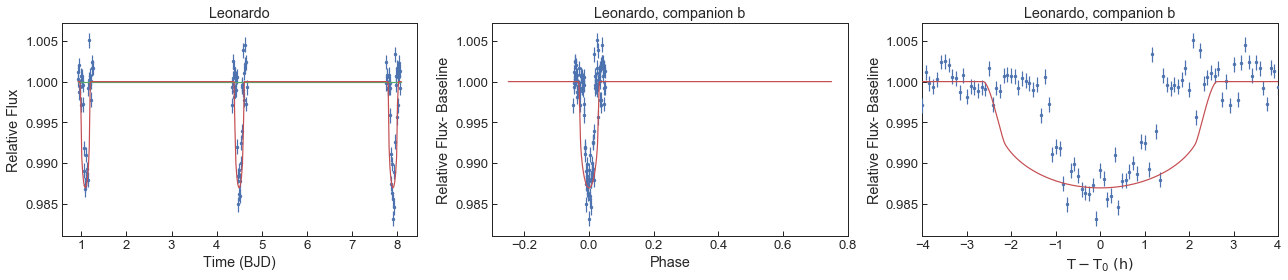

In [74]:
if 'show_step_5' in INPUT and INPUT['show_step_5']==True:
    
    from allesfitter.general_output import show_initial_guess
    import matplotlib.pyplot as plt

    fig_list = show_initial_guess(INPUT['datadir'], do_logprint=False, return_figs=True)
    
    for fig in fig_list:
        plt.show(fig)

In [75]:
if 'show_step_5' in INPUT and INPUT['show_step_5']==True:

    BUTTONS['confirm_plots'] = widgets.Button(description='Looks good', button_style='')
    display(BUTTONS['confirm_plots'])
    
    def check_plots(change):
        clear_output()
        display(BUTTONS['confirm_plots'])
        BUTTONS['confirm_plots'].style.button_color = 'lightgreen'   
        INPUT['show_step_6'] = True
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
    BUTTONS['confirm_plots'].on_click(check_plots)
    
# else:  
#     print('Complete previous steps first.')

Button(description='Looks good', style=ButtonStyle())

<IPython.core.display.Javascript object>

# 6. tighter priors on errors and baselines
This will take a couple of minutes. Make sure your initial guess above is very good. This will subtract the model from the data and evaluate the remaining noise patterns to estimate errors, jitter and GP baselines.

In [79]:
if 'show_step_6' in INPUT and INPUT['show_step_6']==True:

    def estimate_tighter_priors(change):
    
        print('\nEstimating errors and baselines... this will take a couple of minutes. Please be patient, you will get notified once everything is completed.\n')

        #::: run MCMC fit to estimate errors and baselines
        estimate_noise(INPUT['datadir'])

        #::: delete the rows containing the default (zero) errors and baselines from the params.csv file
        clean_up_csv( os.path.join( INPUT['datadir'], 'params.csv' ), N_last_rows=INPUT['N_last_rows'] )


        #::: write new rows into params.csv
        #::: errors
        fwrite_params_line('#errors per instrument,')

        for i, inst in enumerate(INPUT['inst_phot']):         
            #::: read in the summary file
            summaryfile = os.path.join( INPUT['datadir'], 'priors', 'summary_phot.csv' )
            priors2 = np.genfromtxt(summaryfile, names=True, delimiter=',', dtype=None)
            priors = {}
            for key in priors2.dtype.names:
                priors[key] = np.atleast_1d(priors2[key])

            median = priors['log_yerr_median'][i]
            err = 5.*np.max([ float(priors['log_yerr_ll'][i]), float(priors['log_yerr_ul'][i]) ])
            median, err, _ = round_txt_separately(median,err,err)
            fwrite_params_line('log_err_flux_'+inst+','+median+',1,trunc_normal -23 0 '+median+' '+err+',$\log{\sigma_\mathrm{'+inst+'}}$,')

        for i, inst in enumerate(INPUT['inst_rv']):   
            #::: read in the summary file
            summaryfile = os.path.join( INPUT['datadir'], 'priors', 'summary_rv.csv' )
            priors2 = np.genfromtxt(summaryfile, names=True, delimiter=',', dtype=None)
            priors = {}
            for key in priors2.dtype.names:
                priors[key] = np.atleast_1d(priors2[key])

            median = priors['log_yerr_median'][i]
            err = 5.*np.max([ float(priors['log_yerr_ll'][i]), float(priors['log_yerr_ul'][i]) ])
            median, err, _ = round_txt_separately(median,err,err)
            fwrite_params('log_jitter_rv_'+inst+','+median+',1,trunc_normal -23 0 '+median+' '+err+',$\log{\sigma_\mathrm{jitter; '+inst+'}}$,')


        #::: write new rows into params.csv
        #::: baselines
        fwrite_params_line('#baseline per instrument,')

        for i, inst in enumerate(INPUT['inst_phot']):         
            #::: read in the summary file
            summaryfile = os.path.join( INPUT['datadir'], 'priors', 'summary_phot.csv' )
            priors2 = np.genfromtxt(summaryfile, names=True, delimiter=',', dtype=None)
            priors = {}
            for key in priors2.dtype.names:
                priors[key] = np.atleast_1d(priors2[key])

            median = priors['gp_log_sigma_median'][i]
            err = 5.*np.max([ float(priors['gp_log_sigma_ll'][i]), float(priors['gp_log_sigma_ul'][i]) ])
            median, err, _ = round_txt_separately(median,err,err)
            fwrite_params_line('baseline_gp1_flux_'+inst+','+median+',1,trunc_normal -23 23 '+median+' '+err+',$\mathrm{gp: \log{\sigma} ('+inst+')}$,')

            median = priors['gp_log_rho_median'][i]
            err = 5.*np.max([ float(priors['gp_log_rho_ll'][i]), float(priors['gp_log_rho_ul'][i]) ])
            median, err, _ = round_txt_separately(median,err,err)
            fwrite_params_line('baseline_gp2_flux_'+inst+','+median+',1,trunc_normal -23 23 '+median+' '+err+',$\mathrm{gp: \log{\\rho} ('+inst+')}$,')

            
        #::: confirm
        BUTTONS['estimate_tighter_priors'].style.button_color = 'lightgreen'   
        print('Done.')
        INPUT['show_step_7'] = True
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
            
        
        
    def skip(change):
        BUTTONS['skip'].style.button_color = 'lightgreen'     
        print('Skipped.')
        INPUT['show_step_7'] = True
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
    
# else:  
#     print('Complete previous steps first.')

In [80]:
if 'show_step_6' in INPUT and INPUT['show_step_6']==True:
    
    BUTTONS['estimate_tighter_priors'] = widgets.Button(value=False, description='Estimate tighter priors')
    BUTTONS['skip'] = widgets.Button(value=False, description='Skip')
    display( widgets.HBox([BUTTONS['estimate_tighter_priors'],BUTTONS['skip']]))
    
    BUTTONS['estimate_tighter_priors'].on_click(estimate_tighter_priors)
    
    BUTTONS['skip'].on_click(skip)

Skipped.


<IPython.core.display.Javascript object>

# 7. run the fit

In [82]:
if 'show_step_7' in INPUT and INPUT['show_step_7']==True:
    
    try:
        from importlib import reload
    except:
        pass
    
    try:
        from imp import reload
    except:
        pass
    
    import allesfitter
    reload(allesfitter)
        
    button_run_ns_fit = widgets.Button(description='Run NS fit', button_style='')
    button_run_mcmc_fit = widgets.Button(description='Run MCMC fit', button_style='')
    hbox = widgets.HBox([button_run_ns_fit, button_run_mcmc_fit])
    display(hbox)
    
    def run_ns_fit(change):
        button_run_ns_fit.style.button_color = 'lightgreen'
        allesfitter.ns_fit(INPUT['datadir'])
        allesfitter.ns_output(INPUT['datadir'])
    
    def run_mcmc_fit(change):
        button_run_mcmc_fit.style.button_color = 'lightgreen'
        allesfitter.mcmc_fit(INPUT['datadir'])
        allesfitter.mcmc_output(INPUT['datadir'])
        
    button_run_ns_fit.on_click(run_ns_fit)
    button_run_mcmc_fit.on_click(run_mcmc_fit)
    
    
# else:
#     print('Complete previous steps first.')